# Predicting Machine Failure

The ability to predict when a mechanical system will fail can be important for many reasons. In some cases, knowing when a system will fail can promote both national security and personal safety while also inhibiting maintenence costs. 

Despite the importance of predicting mechanical failure, relevant data can be difficult to obtain. For this reason Stephan Matzka at [the School of Engineering at the University of Applied Sciences](https://www.htw-berlin.de/en/) in Berlin has produced a synthetic machine failure dataset and made it [publically available](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset).

In this project I use this dataset to train a set of models to predict when the simulated machine will fail. I present various visualizations that help make sense of the source data, evaluate the models, and explain the machine's failure conditions.

## Import dependencies

First we will import dependencies that will be used in this analysis.

In [114]:
# Import basic dependencies
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler  #for normalization

# Import dependencies for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



## Load the dataset

Next, load the raw dataset into a pandas dataframe. 

In [115]:
df_raw = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv')

## Preview the raw data
Let's examine the first set of rows to get a better sense of what information is in the dataset.

In [121]:
# Preview the first few rows of data
df_raw.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [122]:
# Get basic information about the data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Machine failure: the target variable
Each row in this dataframe is a datapoint that captures a snapshot of the machine's condition at a given time across several features. There are 10,000 such datapoints. We will use these datapoints to help predict whether the machine will fail or not. That information is represented by values of 1 (failure) and 0 (non-failure) in the 'Machine failure' column. This column is our target variable.

### A clean dataset
This data is relatively clean and will require minimal preprocessing. None of the datapoints contain null values. And most of the datatypes are quantitative rather than categorical.

### Dropping columns
Although the dataset is relatively and easy to work with, we will drop some columns for the purpose of this analysis. In particular, we will drop the 'UDI' and 'Product ID' columns. According to the [source](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset), the 'UDI' column simply contains a unique identifier for each of the 10,000 datapoints. Similarly, the 'Product ID' column contains unique IDs for the products in the 'Type' column. We can confirm this with a quick check.

In [161]:
# Check columns for unique values
df_raw.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

### Ignoring types of machine failure for simplicity
While the 'Machine failure' column contains data about whehter or not the machine is in a failed state, other columns contain information representing the particular type of failure that has or has not occured: tool wear failure ('TWF'), heat dissipation failure ('HDF'), power failure ('PWF'), overstrain failure ('OSF'), or random failure ('RNF'). 

For simplicity, this analysis will focus on trying to predict machine faiulre *simplciter* rather than trying to predict the types of machine failure that might occur. Because of this, it will be important to drop these columns from the dataset. If we fail to do this, then the models won't really learn to predict machine failure. Instead they will simply learn to identify that the machine is *some* failed state because we have told it that it is in some *particular* of failed state. 

### Handling the remaining categorical column with one-hot-encoding
The one categorical column that we will not drop is the 'Type' column. Information in this column indicates the quality of the tool and is represented by letters 'H', 'M', and 'L' for high, medium, and low, respectively. To make this information suitible for this machine learning task, I will perform one-hot encoding to represent these categorical values numerically as vectors. 

## Preprocessing the data
Given these observations, let's now create our datasets, splitting it into X our set of features, and y, our set of target variables.

In [168]:
# Drop identifier and particular failure type columns
df_dropped_columns = df_raw.drop(['UDI', 'Product ID', 'TWF','HDF','PWF','OSF','RNF'],axis=1)

In [170]:
# Create X dataframe by performing one-hot encoding on df_dropped_columns
X = pd.get_dummies(df_dropped_columns)

In [159]:
# Create target y dataframe
y = df_raw['Machine failure']

In [172]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Machine failure, dtype: int64

Preview these dataframes to see how they look now.

In [173]:
# Preview X
X.head() 

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,1,0


In [174]:
# Preview y
y.head() 

0    0
1    0
2    0
3    0
4    0
Name: Machine failure, dtype: int64

#### Normalization
To facilitate machine learning, we can normalize the data.

In [185]:
# create a MinMaxScaler object
scaler_normalized = MinMaxScaler()

# normalize the data using the scaler
X_normalized = pd.DataFrame(scaler_normalized.fit_transform(X))

In [186]:
X_normalized.head()

,0,1,2,3,4,5,6,7,8
0,0.304348,0.358025,0.222934,0.535714,0.000000,0.0,0.0,0.0,1.0
1,0.315217,0.370370,0.139697,0.583791,0.011858,0.0,0.0,1.0,0.0
2,0.304348,0.345679,0.192084,0.626374,0.019763,0.0,0.0,1.0,0.0
3,0.315217,0.358025,0.154249,0.490385,0.027668,0.0,0.0,1.0,0.0
4,0.315217,0.370370,0.139697,0.497253,0.035573,0.0,0.0,1.0,0.0


<AxesSubplot:>

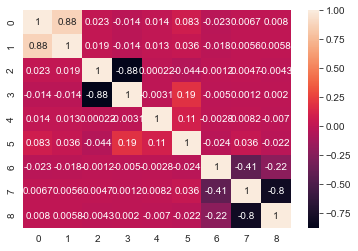

In [187]:
# plot heatmap
sns.heatmap(X_normalized.corr(), annot=True)

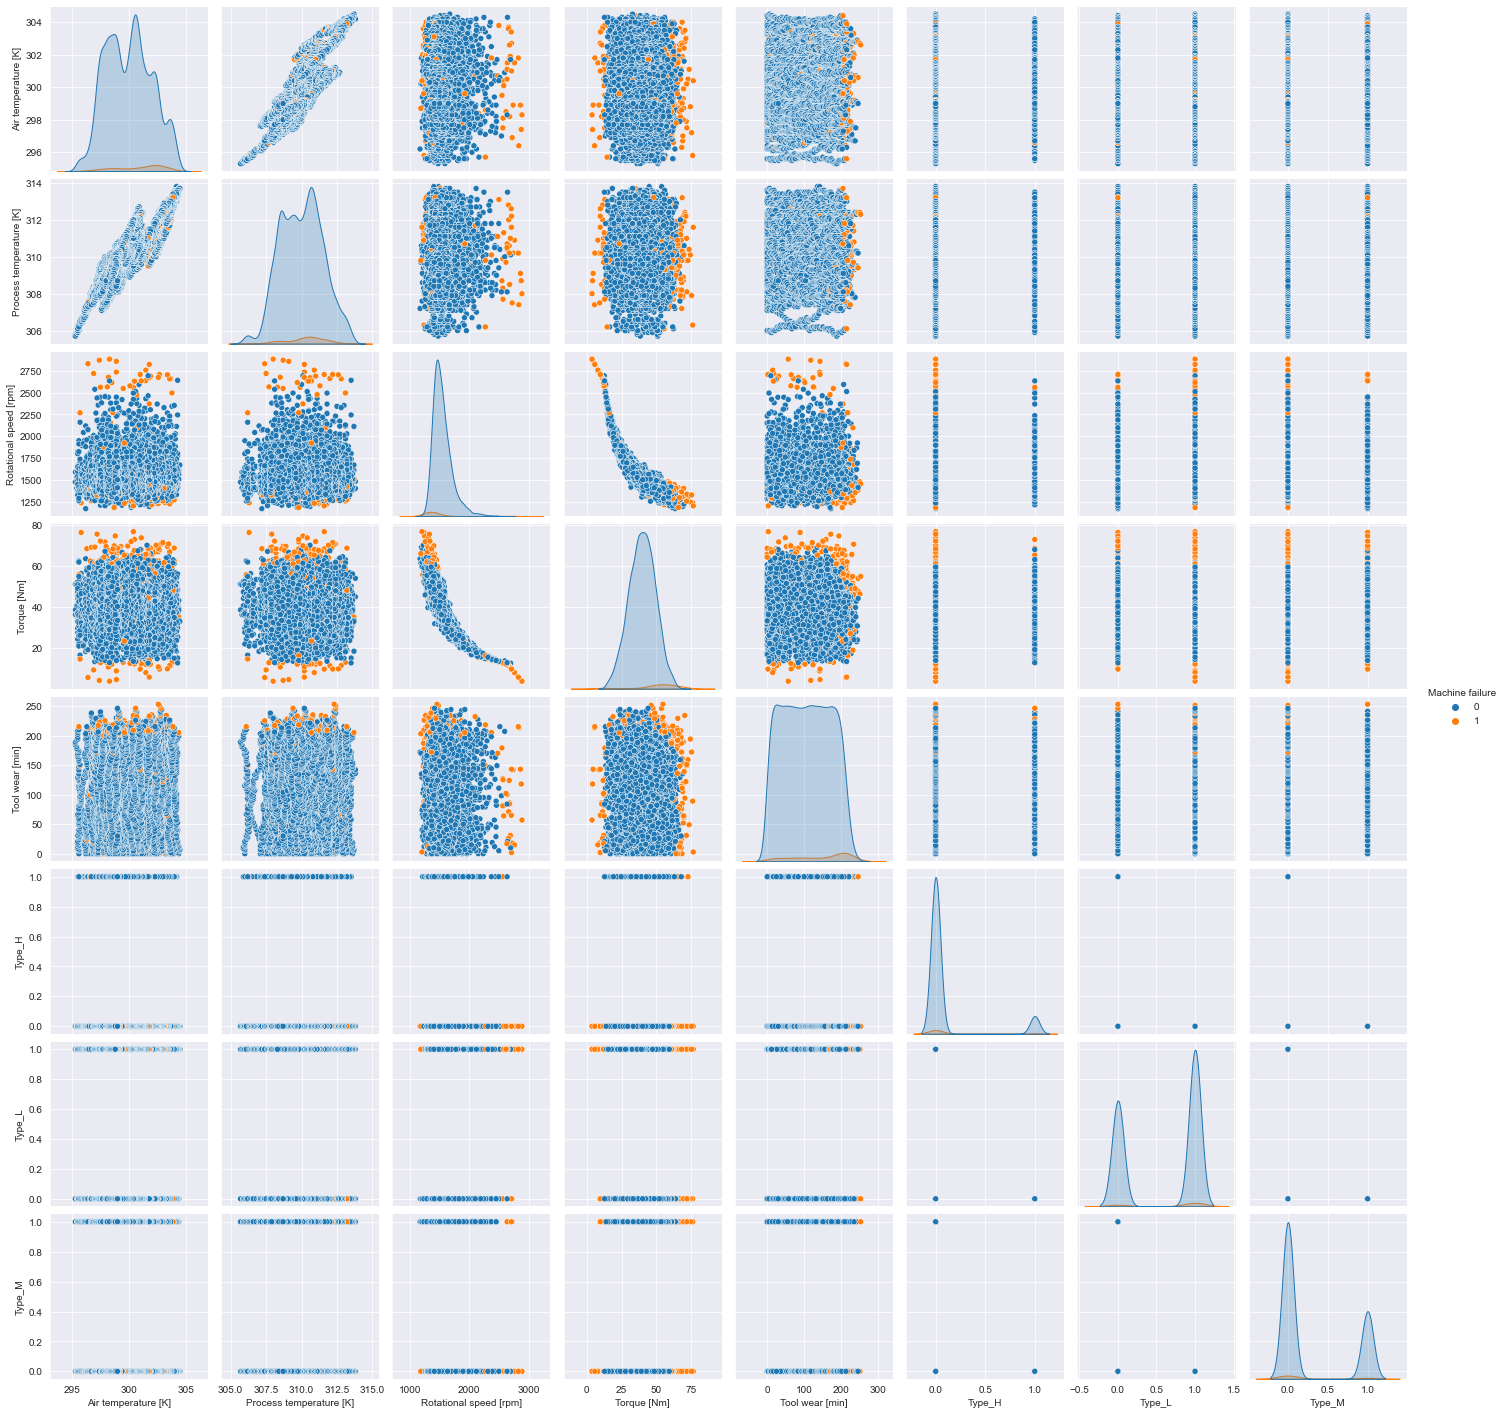

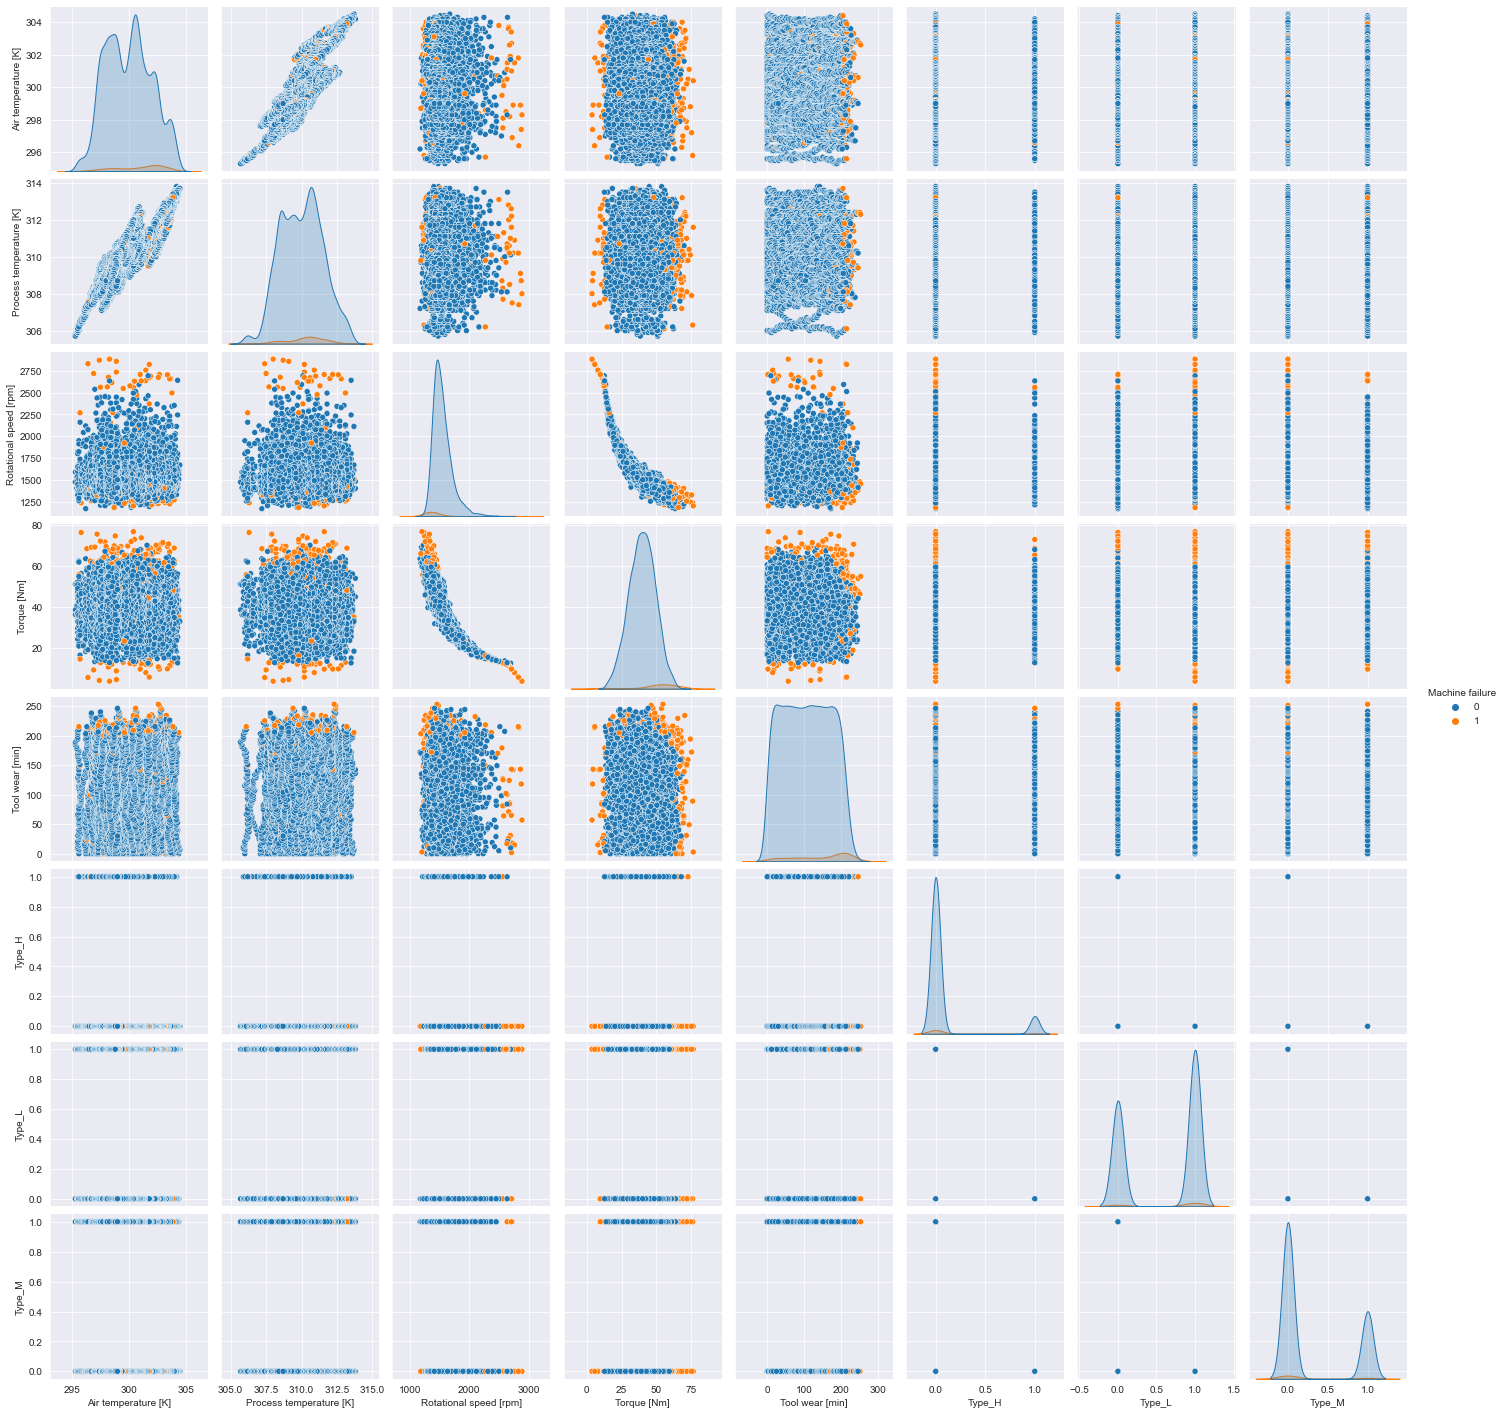

In [188]:
# further visualizations
import seaborn as sns
import pandas as pd


# Plot a pairplot
sns.pairplot(X, hue="Machine failure")



In [107]:
df_raw.sample(frac = 0.2).iloc[:, 2:9]


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
5673,L,302.2,311.6,1462,50.0,51,0
558,L,297.5,309.4,1650,34.6,142,0
5512,L,302.8,312.2,1682,30.9,58,0
4207,M,302.3,310.9,1710,30.4,218,1
58,M,298.8,309.0,1661,29.5,162,0
...,...,...,...,...,...,...,...
145,L,298.5,308.4,1513,33.6,172,0
889,L,295.6,306.1,1389,46.2,113,0
6248,L,300.8,310.1,1405,61.2,189,1
1164,L,297.1,308.1,1754,30.3,206,0


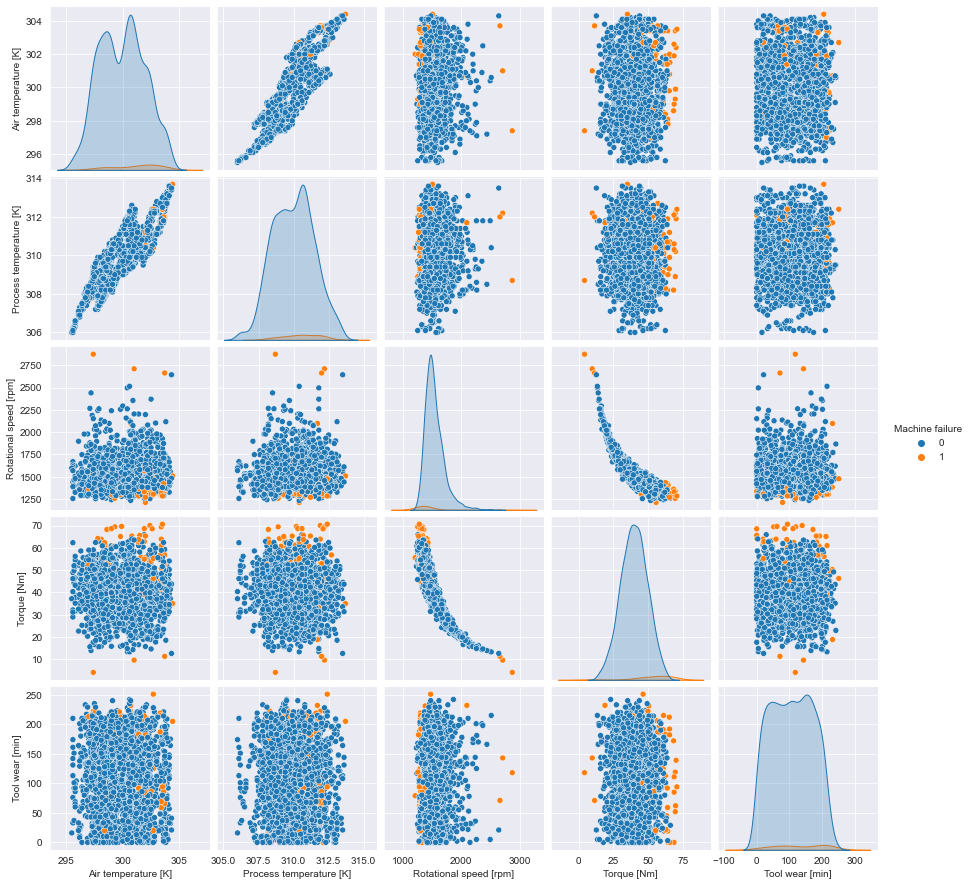

In [108]:
# Plot a pairplot
sns.pairplot(df_raw.sample(frac = 0.2).iloc[:, 2:9], hue="Machine failure")


0    0.9661
1    0.0339
Name: Machine failure, dtype: float64


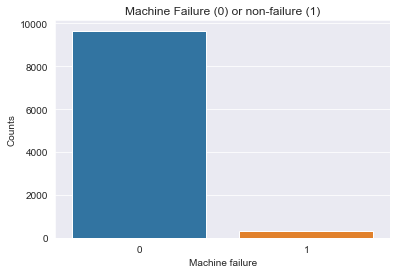

In [91]:
# check for class imbalance
print(df_raw['Machine failure'].value_counts(normalize=True))


# import dependencies for this visualization
import seaborn as sns
import matplotlib.pyplot as plt


# create a count plot using Seaborn
sns.countplot(x="Machine failure", data=df_raw)

# customize the plot
plt.xlabel("Machine failure")
plt.ylabel("Counts")
plt.title("Machine Failure (0) or non-failure (1)")

# show plot
plt.show()






In [ ]:
# normalize the data for deep learning model

# create a MinMaxScaler object
scaler_normalized = MinMaxScaler()

# normalize the data using the scaler
X_normalized = scaler_normalized.fit_transform(X)

# print the normalized data
print(X_normalized)


[[0.30434783 0.35802469 0.22293364 ... 0.         0.         1.        ]
 [0.31521739 0.37037037 0.13969732 ... 0.         1.         0.        ]
 [0.30434783 0.34567901 0.19208382 ... 0.         1.         0.        ]
 ...
 [0.40217391 0.35802469 0.27764843 ... 0.         0.         1.        ]
 [0.40217391 0.37037037 0.13969732 ... 1.         0.         0.        ]
 [0.40217391 0.37037037 0.19324796 ... 0.         0.         1.        ]]


In [ ]:
# Create a StandardScaler object
scaler_standardized = StandardScaler()

# Fit the scaler to the data
scaler_standardized.fit(X)

# Transform the data using the fitted scaler
X_standardized = scaler_standardized.transform(X)
print(X_standardized)

[[-0.95238944 -0.94735989  0.06818514 ... -0.33388861 -1.22474487
   1.52861702]
 [-0.90239341 -0.879959   -0.72947151 ... -0.33388861  0.81649658
  -0.65418609]
 [-0.95238944 -1.01476077 -0.22744984 ... -0.33388861  0.81649658
  -0.65418609]
 ...
 [-0.50242514 -0.94735989  0.59251888 ... -0.33388861 -1.22474487
   1.52861702]
 [-0.50242514 -0.879959   -0.72947151 ...  2.99501081 -1.22474487
  -0.65418609]
 [-0.50242514 -0.879959   -0.2162938  ... -0.33388861 -1.22474487
   1.52861702]]


Visualizations -------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# visualizations

import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
tips = sns.load_dataset("tips")

# create scatterplot
sns.scatterplot(x="total_bill", y="tip", hue="sex", data=tips)

# show plot
plt.show()



In [63]:
# unbias the data
# perform Synthetic Minority Over-sampling Technique (SMOTE)?

Epoch 1/10
250/250 [==============================] - 1s 5ms/step - loss: 0.2810 - accuracy: 0.9320 - precision_2: 0.0567 - recall_2: 0.0612 - auc_2: 0.4198 - val_loss: 0.1429 - val_accuracy: 0.9695 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.3335
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.1551 - accuracy: 0.9653 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2: 0.4406 - val_loss: 0.1380 - val_accuracy: 0.9695 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.6560
Epoch 3/10
250/250 [==============================] - 0s 1ms/step - loss: 0.1466 - accuracy: 0.9653 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2: 0.6795 - val_loss: 0.1281 - val_accuracy: 0.9695 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.7522
Epoch 4/10
250/250 [==============================] - 0s 1ms/step - loss: 0.1386 - accuracy: 0.9653 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2

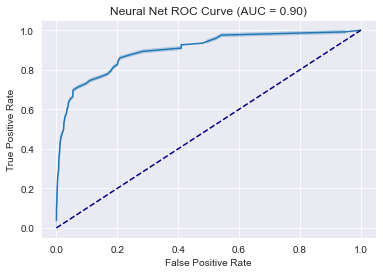

<Figure size 432x288 with 0 Axes>

In [68]:
# build the deep learning model
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# define the model architecture
dl_model = Sequential()
dl_model.add(Dense(32, activation='relu', input_dim=X_normalized.shape[1]))
dl_model.add(Dense(16, activation='relu'))
dl_model.add(Dense(1, activation='sigmoid'))

# compile the model with additional metrics
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# train the model
dl_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# predict probabilities and classes for test data
y_pred_proba = dl_model.predict(X_test)
y_pred = np.round(y_pred_proba)




In [111]:
# f1 score?

# average precision? maybe better, not biased

# try random forest, 
# gradient boosting, 
# log regression, 
# light gbm (it will make splits based ...looks at leaf rather than split... looks for pure nodes ), 
# xg boost, 
# chapley values (checks for marginal impact of the feature),
# stats models logistic regression

# for logistic regrission print out the summary



#go with average precision score



In [ ]:
statsmodels –– Logit().fit()
https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
log_reg = sm.Logit(ytrain, Xtrain).fit()
log_reg.summary()

In [ ]:
from sklearn.metrics import average_precision_score
# Predicting with logit 
y_pred = result.predict(X_test[subset])
avg_prec_score = average_precision_score(y_true, y_pred)

In [110]:
# randomized grid search


# bayesian hyperparameter search; looks for better tuples of hyperparameters (only do with training set)

# validation set: do feature selection; use entire training set and testing

# random forest, 


In [ ]:
# evaluate the model using various metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", auc_roc)


# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
sns.set_style("darkgrid")
sns.lineplot(x=fpr, y=tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Net ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.show()

# clear plot
plt.clf()


Type_H: 3.923
Process temperature [K]: 2.425
Rotational speed [rpm]: 2.227
Type_M: 1.926
Type_L: 1.659
Tool wear [min]: 0.373
Torque [Nm]: -1.008
Air temperature [K]: -2.234


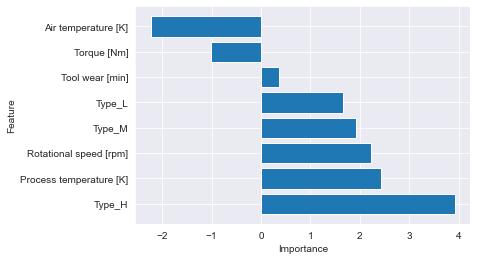

In [70]:
# -------------------------------------------------------------------------------
# Feature importance plot
# get the weights for the first layer
weights = dl_model.get_weights()[0]

# calculate the feature importances as the sum of the absolute weights for each feature
importances = weights.sum(axis=1)

# print out the feature importances in descending order
sorted_importances = sorted(list(zip(X.columns, importances)), key=lambda x: -x[1])
for feature, importance in sorted_importances:
    print(f'{feature}: {importance:.3f}')

# calculate the feature importances as the sum of the absolute weights for each feature
importances = weights.sum(axis=1)

# create a bar plot of the feature importances
sorted_importances = sorted(list(zip(X.columns, importances)), key=lambda x: -x[1])
plt.barh([x[0] for x in sorted_importances], [x[1] for x in sorted_importances])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()







In [112]:
# perform cross validation

# visualize clusters since there are different failure conditions


3 NO LINEAR AND THAT'S 





DO LOG REGRESSION W STATS MODELS, SHOW SUMMARY TO BEGIN TO DRAW CAUSAL

build the tree models
PRINT OUT FEATURE importance for the best performing 
TALK ABOUT similarities bt the best feature importance and log regression p values


RANDOM FOREST AND LIGHT GBM ARE ENSEMBLE




GOOD WAYS TO EVALUATE THIS CLASSIFICATION PROBLEM

average precision score 

SyntaxError: invalid syntax (<ipython-input-112-490fba963a67>, line 6)

In [ ]:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html




In [ ]:
Matt Mecca8:30 PM
pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv')
https://archive.ics.uci.edu/ml/machine-learning-databases/00601/
Matt Mecca8:43 PM
plt.title("whatever")
plt.figure(size = (15, 10))
Matt Mecca8:46 PM
df_raw.sample(frac = 0.2).iloc[:, 2:9]
Matt Mecca8:57 PM
RandomForest
GradientBoosting
LogisticRegression to start
LightGBM or XGBoost
Matt Mecca9:02 PM
statsmodels –– Logit().fit()
https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
log_reg = sm.Logit(ytrain, Xtrain).fit()
log_reg.summary()
Matt Mecca9:06 PM
from sklearn.metrics import average_precision_score
# Predicting with logit 
y_pred = result.predict(X_test[subset])
avg_prec_score = average_precision_score(y_true, y_pred)
Matt Mecca9:14 PM
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
qnk-jzzd-ddk